# Understanding concept of Causal Inference and its Connections to Machine Learning (Using DoWhy+EconML) 
This tutorial presents a walk-through on using DoWhy+EconML libraries for causal inference. Along the way, we'll highlight the connections to machine learning---how machine learning helps in building causal effect estimators, and how causal reasoning can be help build more robust machine learning models. 

Examples of data science questions that are fundamentally causal inference questions: 
* **A/B experiments**: If I change the algorithm, will it lead to a higher success rate?
* **Policy decisions**: If we adopt this treatment/policy, will it lead to a healthier patient/more revenue/etc.?
* **Policy evaluation**: Knowing what I know now, did my policy help or hurt?
* **Credit attribution**: Are people buying because of the recommendation algorithm? Would they have bought anyway?

In this tutorial, you will:
* Learn how causal reasoning is necessary for decision-making, and the difference between a prediction and decision-making task.
<br>

* Get hands-on with estimating causal effects using the four steps of causal inference: **model, identify, estimate and refute**.
<br>

* See how DoWhy+EconML can help you estimate causal effects with **4 lines of code**, using the latest methods from statistics and machine learning to estimate the causal effect and evaluate its robustness to modeling assumptions.
<br>

* Work through **real-world case-studies** with Jupyter notebooks on applying causal reasoning in different scenarios including estimating impact of a customer loyalty program on future transactions, predicting which users will be positively impacted by an intervention (such as an ad), pricing products, and attributing which factors contribute most to an outcome.
<br>

* Learn about the connections between causal inference and the challenges of modern machine learning models.

## Why causal inference?
Many key data science tasks are about decision-making. Data scientists are regularly called upon to support decision-makers at all levels, helping them make the best use of data in support of achieving desired outcomes. For example,  an executive making investment and resourcing decisions, a marketer determining discounting policies, a product team prioritizing which features to ship, or a doctor deciding which treatment to administer to a patient.  

Each of these decision-makers is asking a what-if question.  Data-driven answers to such questions require understanding the *causes* of an event and how to take action to improve future outcomes.

### Defining a causal effect 
Suppose that we want to find the causal effect of taking an action A on the outcome Y. To define the causal effect, consider two worlds: 
1. World 1 (Real World): Where the action A was taken and Y observed
2. World 2 (*Counterfactual* World): Where the action A was not taken (but everything else is the same) 

Causal effect is the difference between Y values attained in the real world versus the counterfactual world. 
$${E}[Y_{real, A=1}] - E[Y_{counterfactual, A=0}]$$

![Real and Counterfactual Worlds](images/real_vs_counterfactual_world.png)

In other words, A causes Y iff changing A leads to a change in Y,
*keeping everything else constant*. Changing A while keeping everything else constant is called an **intervention**, and represented by a special notation, $do(A)$. 

Formally, causal effect is the magnitude by which Y is changed by a unit *interventional* change in A:
$$E[Y│do(A=1)]−E[Y|do(A=0)]$$

To estimate the effect, the *gold standard* is to conduct a randomized experiment where a randomized subset of units is acted upon ($A=1$) and the other subset is not ($A=0$). These subsets approximate the disjoint real and counterfactual worlds and randomization ensures that there is not systematic difference between the two subsets (*"keeping everything else constant"*). 

However, it is not always feasible to a run a randomized experiment. To answer causal questions, we often need to rely on observational or logged data. Such observed data is biased by correlations and unobserved confounding and thus there are systematic differences in which units were acted upon and which units were not. For example, a new marketing campaign may be deployed during the holiday season, a new feature may only have been applied to high-activity users, or the older patients may have been more likely to receive the new drug, and so on. The goal of causal inference methods is to remove such correlations and confounding from the data and estimate the *true* effect of an action, as given by the equation above. 


### The difference between prediction and causal inference

<table><tr>
<td> <img src="images/supervised_ml_schematic.png" alt="Drawing" style="width: 400px;"/> </td>
<td> <img src="images/causalinference_schematic.png" alt="Drawing" style="width: 400px;"/> </td>
</tr></table>

### Two fundamental challenges for causal inference
We never observe the counterfactual world

* Cannot directly calculate the causal effect
* Must estimate the counterfactuals 
* Challenges in validation

Multiple causal mechanisms can be fit to a single data distribution
* Data alone is not enough for causal inference
* Need domain knowledge and assumptions


## The four steps of causal inference

Since there is no ground-truth test dataset available that an estimate can be compared to, causal inference requires a series of principled steps to achieve a good estimator. 

Let us illustrate the four steps through a sample dataset. This tutorial requires you to download two libraries: DoWhy and EconML. Both can be installed by the following command: `pip install dowhy econml`.

In [6]:
# Required libraries
import dowhy
from dowhy import CausalModel
import dowhy.datasets

# Avoiding unnecessary log messges and warnings
import logging
logging.getLogger("dowhy").setLevel(logging.WARNING)
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Load some sample data
data = dowhy.datasets.linear_dataset(
    beta=10,
    num_common_causes=5,
    num_instruments=2,
    num_samples=10000,
    treatment_is_binary=True,
    stddev_treatment_noise=10)

**I. Modeling**

The first step is to encode our domain knowledge into a causal model, often represented as a graph. The final outcome of a causal inference analysis depends largely on the input assumptions, so this step is quite important. To estimate the causal effect, most common problems involve specifying two types of variables: 

1. **Confounders (common_causes)**: These are variables that cause both the action and the outcome. As a result, any observed correlation between the action and the outcome may simply be due to the confounder variables, and not due to any causal relationship from the action to the outcome. 

2. **Instrumental Variables (instruments)**: These are special variables that cause the action, but do not directly affect the outcome. In addition, they are not affected by any variable that affects the outcome. Instrumental variables can help reduce bias, if used in the correct way. 

In [7]:
# I. Create a causal model from the data and domain knowledge.
model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    common_causes=data["common_causes_names"],
    instruments=data["instrument_names"])

To visualize the graph, we can write,

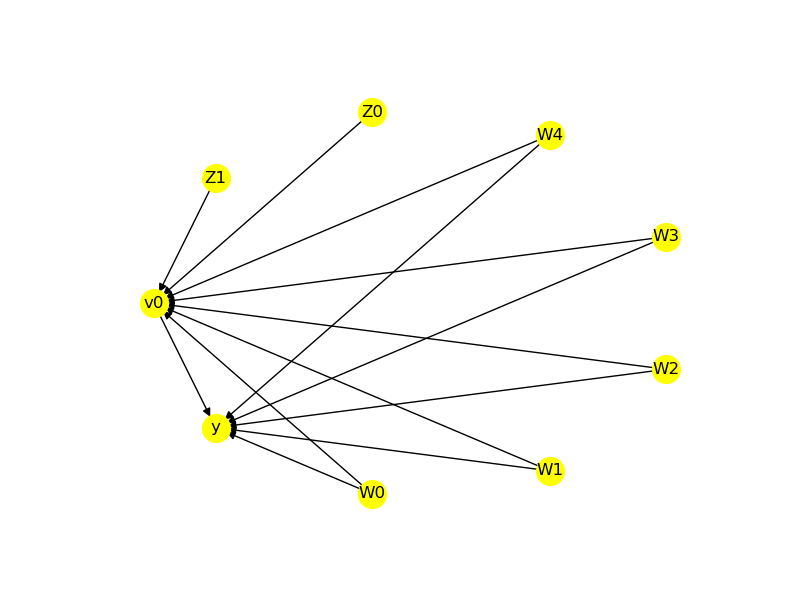

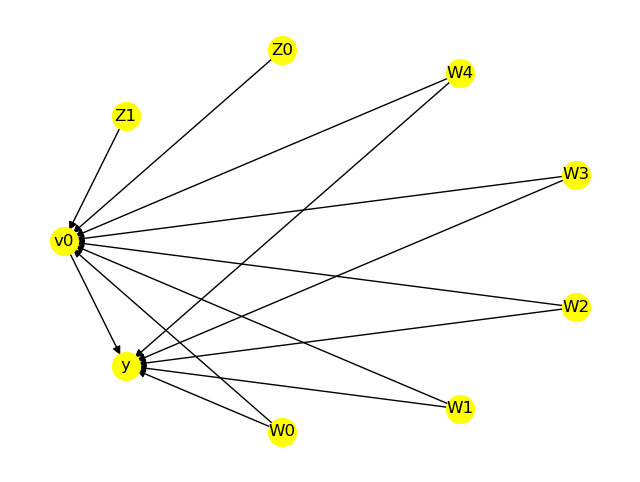

In [8]:
model.view_model(layout="dot")
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In general, you can specify a causal graph that describes the mechanisms of the data-generating process for a given dataset. Each arrow in the graph denotes a causal mechanism: "A->B" implies that the variable A causes variable B.


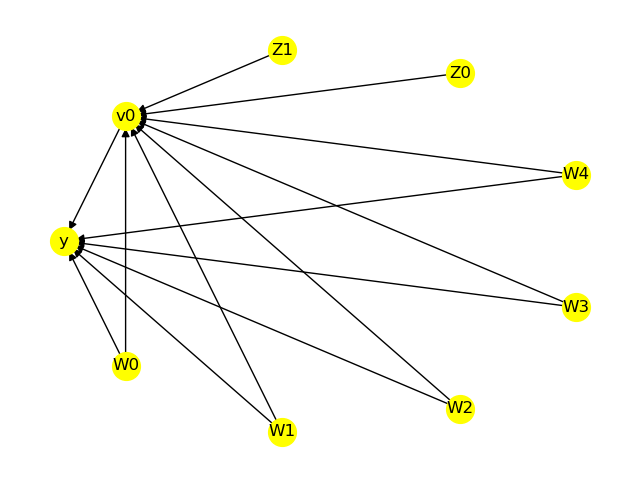

In [9]:
# I. Create a causal model from the data and given graph.
model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"][0],
    outcome=data["outcome_name"][0],
    graph=data["gml_graph"])
model.view_model(layout="dot")

**II. Identification**

Both ways of providing domain knowledge (either through named variable sets of confounders and instrumental variables, or through a causal graph) correspond to an underlying causal graph. Given a causal graph and a target quantity (e.g., effect of A on B), the process of identifcation is to check whether the target quantity can be estimated given the observed variables. Importantly, identification only considers the names of variables that are available in the observed data; it does not need access to the data itself. Related to the two kinds of variables above, there are two main identification methods for causal inference. 

1. **Backdoor criterion** (or more generally, adjustment sets): If all common causes of the action A and the outcome Y are observed, then the backdoor criterion implies that the causal effect can be identified by conditioning on all the common causes. This is a simplified definition (refer to Chapter 3 of the CausalML book for a formal definition).
$$ E[Y│do(A=a)] = E_W E[Y|A=a, W=w]$$
       
where $W$ refers to the set of common causes (confounders) of $A$ and $Y$. 

2. **Instrumental variable (IV) identification**: If there is an instrumental variable available, then we can estimate effect even when any (or none) of the common causes of action and outcome are unobserved. The IV identification utilizes the fact that the instrument only affects the action directly, so the effect of the instrument on the outcome can be broken up into two sequential parts: the effect of the instrument on the action and the effect of the action on the treatment. It then relies on estimating the effect of the instrument on the action and the outcome to estimate the effect of the action on the outcome. For a binary instrument, the effect estimate is given by,
    
 $$ E[Y│do(A=1)] -E[Y│do(A=0)]  =\frac{E[Y│Z=1]- E[Y│Z=0]}{E[A│Z=1]- E[A│Z=0]} $$

In [10]:
# II. Identify causal effect and return target estimands
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W1,W4,W3,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W4,W3,W2,U) = P(y|v0,W0,W1,W4,W3,W2)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



**III. Estimation**

As the name suggests, the estimation step involves building a statistical estimator that can compute the target estimand identified in the previous step. Many estimators have been proposed for causal inference. DoWhy implements a few of the standard estimators while EconML implements a powerful set of estimators that use machine learning.   

We show an example of using Propensity Score Stratification using DoWhy, and a machine learning-based method called Double-ML using EconML.

In [11]:
# III. Estimate the target estimand using a statistical method.
propensity_strat_estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.dowhy.propensity_score_stratification")

print(propensity_strat_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W1,W4,W3,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W4,W3,W2,U) = P(y|v0,W0,W1,W4,W3,W2)

## Realized estimand
b: y~v0+W0+W1+W4+W3+W2
Target units: ate

## Estimate
Mean value: 9.919903888879816



In [12]:
import econml
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, 
                                    method_name="backdoor.econml.dml.DML",
                                    method_params={
                                        'init_params': {'model_y':GradientBoostingRegressor(),
                                                        'model_t': GradientBoostingRegressor(),
                                                        'model_final':LassoCV(fit_intercept=False), },
                                        'fit_params': {}
                                     })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W1,W4,W3,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W4,W3,W2,U) = P(y|v0,W0,W1,W4,W3,W2)

## Realized estimand
b: y~v0+W0+W1+W4+W3+W2 | 
Target units: ate

## Estimate
Mean value: 10.016700141264158
Effect estimates: [[10.01670014]]



**IV. Refutation**

Finally, checking robustness of the estimate is probably the most important step of a causal analysis. We obtained an estimate using Steps 1-3, but each step may have made certain assumptions that may not be true. Absent of a proper validation "test" set, this step relies on *refutation* tests that seek to refute the correctness of an obtained estimate using properties of a good estimator. For example, a refutation test (`placebo_treatment_refuter`) checks whether the estimator returns an estimate value of 0 when the action variable is replaced by a random variable, independent of all other variables.   

In [13]:
# IV. Refute the obtained estimate using multiple robustness checks.
refute_results = model.refute_estimate(identified_estimand, propensity_strat_estimate,
                                       method_name="placebo_treatment_refuter")
print(refute_results)

Refute: Use a Placebo Treatment
Estimated effect:9.919903888879816
New effect:0.007032158254071192
p value:0.94



### The DoWhy+EconML solution
We will use the DoWhy+EconML libraries for causal inference. DoWhy provides a general API for the four steps and EconML provides advanced estimators for the Estimation step.  

DoWhy allows you to visualize, formalize, and test the assumptions they are making, so that you can better understand the analysis and avoid reaching incorrect conclusions. It does so by focusing on assumptions explicitly and introducing automated checks on validity of assumptions to the extent possible. As you will see, the power of DoWhy is that it provides a formal causal framework to encode domain knowledge and it can run automated robustness checks to validate the causal estimate from any estimator method.

Additionally, as data becomes high-dimensional, we need specialized methods that can handle known confounding. Here we use EconML that implements many of the state-of-the-art causal estimation approaches.  This package has a common API for all the techniques, and each technique is implemented as a sequence of machine learning tasks allowing for the use of any existing machine learning software to solve these subtasks, allowing you to plug-in the ML models that you are already familiar with rather than learning a new toolkit.  The power of EconML is that you can now implement the state-of-the-art in causal inference just as easily as you can run a linear regression or a random forest.

Together, DoWhy+EconML make answering what if questions a whole lot easier by providing a state-of-the-art, end-to-end framework for causal inference, including the latest causal estimation and automated robustness procedures. 


### A mystery dataset: Can you find out if if there is a causal effect?
To walk-through the four steps, let us consider the **Mystery Dataset** problem. Suppose you are given some data with treatment and outcome. Can you determine whether the treatment causes the outcome, or the correlation is purely due to another common cause?

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import dowhy.datasets, dowhy.plotter

Below we create a dataset where the true causal effect is decided by random variable. It can be either 0 or 1. 

   Treatment    Outcome        w0         s        w1
0  20.953316  42.495548 -3.850148  6.612893  0.855268
1  11.070202  22.040170 -2.199142  0.510192  0.174996
2   6.270778  11.823240  0.750541  1.197374 -0.985342
3  22.229293  44.295189 -3.994776  7.072276  0.390789
4  21.224214  42.555325  3.984648  3.123905 -0.705483


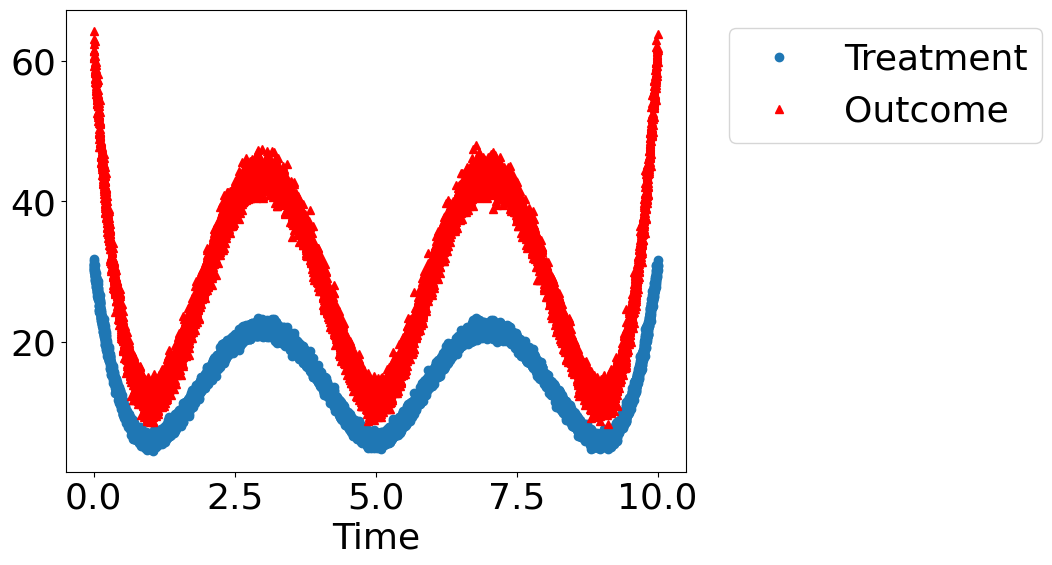

In [15]:
rvar = 1 if np.random.uniform() > 0.2 else 0
is_linear = False # A non-linear dataset. Change to True to see results for a linear dataset.
data_dict = dowhy.datasets.xy_dataset(10000, effect=rvar, 
                                      num_common_causes=2, 
                                      is_linear=is_linear, 
                                      sd_error=0.2) 
df = data_dict['df']                                                                                 
print(df.head())    
dowhy.plotter.plot_treatment_outcome(df[data_dict["treatment_name"]], df[data_dict["outcome_name"]],
                             df[data_dict["time_val"]]) 


#### Model assumptions about the data-generating process using a causal graph 

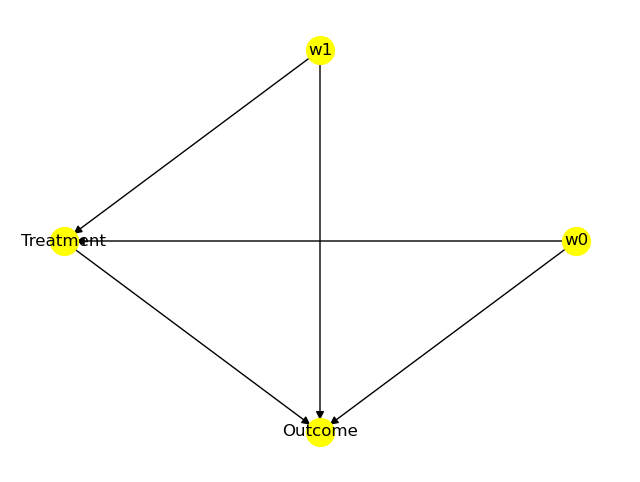

In [16]:
model= CausalModel(                                                                                                                      
        data=df,                                                                                                                         
        treatment=data_dict["treatment_name"],                                                                                           
        outcome=data_dict["outcome_name"],                                                                                               
        common_causes=data_dict["common_causes_names"],                                                                                  
        instruments=data_dict["instrument_names"])                                                                                       
model.view_model(layout="dot")  

#### Identify the correct estimand for the target quantity based on the causal model 

In [17]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                        
────────────(E[Outcome|w0,w1])
d[Treatment]                  
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,w0,w1,U) = P(Outcome|Treatment,w0,w1)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Since this is observed data, the warning asks you if there are any unobserved confounders that are missing in this dataset. If there are, then ignoring them will lead to an incorrect estimate. 
If you want to disable the warning, you can use `proceed_when_unidentifiable=True` as an additional parameter to `identify_effect`.

#### Estimate the target estimand

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                        
────────────(E[Outcome|w0,w1])
d[Treatment]                  
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,w0,w1,U) = P(Outcome|Treatment,w0,w1)

## Realized estimand
b: Outcome~Treatment+w0+w1
Target units: ate

## Estimate
Mean value: 1.997439976571602

Causal Estimate is 1.997439976571602


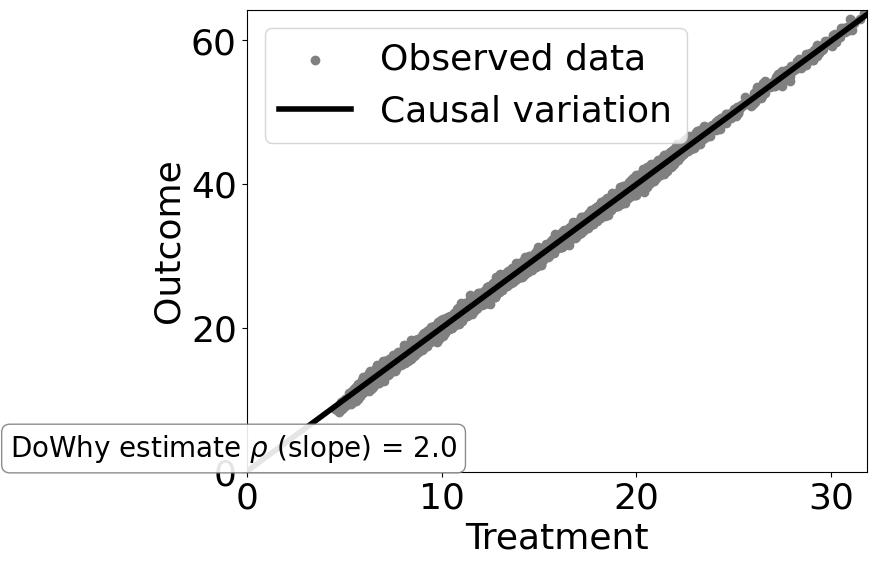

In [18]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print(estimate)
print("Causal Estimate is " + str(estimate.value))

# Plot Slope of line between action and outcome = causal effect                                                                                                 
dowhy.plotter.plot_causal_effect(estimate, df[data_dict["treatment_name"]], df[data_dict["outcome_name"]])

As you can see, for a non-linear data-generating process, the linear regression model is unable to distinguish the causal effect from the observed correlation. 

If the DGP was linear, however, then simple linear regression would have worked. To see that, try setting `is_linear=True` in cell **10** above.

To model non-linear data (and data with high-dimensional confounders), we need more advanced methods. Below is an example using the double machine learning estimator from EconML. This estimator uses machine learning-based methods like gradient boosting trees to learn the relationship between the outcome and confounders, and the treatment and confounders, and then finally compares the residual variation between the outcome and treatment.

In [19]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=2, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                        
────────────(E[Outcome|w0,w1])
d[Treatment]                  
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome then P(Outcome|Treatment,w0,w1,U) = P(Outcome|Treatment,w0,w1)

## Realized estimand
b: Outcome~Treatment+w0+w1 | 
Target units: ate

## Estimate
Mean value: 1.2016019477080162
Effect estimates: [[1.20160195]]



As you can see, the DML method obtains a better estimate, that is closer to the true causal effect of 1. 

#### Check robustness of the estimate using refutation tests

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:1.2016019477080162
New effect:1.1815214213507574
p value:0.6599999999999999



In [21]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=20)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:1.2016019477080162
New effect:0.00017087171847187042
p value:0.3622526272980633

